In [65]:
import os
from copy import deepcopy
from datetime import datetime
from os import listdir

import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import yaml
from keras import models
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

In [3]:
def get_conf(conf_path):
    """Reads configuration file"""
    with open(rf'{conf_path}') as conf_file:
        conf = yaml.safe_load(conf_file)
        return conf

In [4]:
def difference_data(data, d, label, inverse=False):

    for i in range(d):
        if not inverse:
            data[f'{label}'] = data[f'{label}'].diff()
        else:
            data[f'{label}'] += data[f'{label}'].shift(1)
    return data

In [5]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    if len(actual.shape)!=2:
        actual = actual.reshape(actual.shape[0],1)
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2

    smape_score = str(round(sum(diff/avg)/len(forecast) * 100, 2))

    print('SMAPE Error Score: ' + smape_score + ' %')
    return smape_score

In [6]:
def plot_pred_vs_act(actual, predicted, model_type):
    plt.rcParams["figure.figsize"] = [16,9]
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.title(f'Predicted vs Actual Sales for {model_type} Model')

In [7]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [8]:
def xboost(xgb_params, xgb_model_dir, x_train=None, y_train=None, x_test=None, y_test=None, training_req=1):
    """Trains xgboost model and returns it"""

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    file_name = f'xgb_model_{folder_name}.json'

    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, label=y_test, feature_names=list(x_test.columns))

    if training_req:

        params = {'max_depth':xgb_params['XGB_MAX_DEPTH'],
                  'eta':xgb_params['XGB_ETA'],
                  'silent':xgb_params['XGB_SILENT'],
                'subsample':xgb_params['XGB_SUBSAMPLE']}
        num_rounds = xgb_params['XGB_NUM_ROUNDS']

        xgb_model = xgb.train(params, dtrain, num_rounds)

        # save
        xgb_model.save_model(xgb_model_dir+file_name)

    else:
        sorted_xgb_models = [x for x in listdir(xgb_model_dir) if 'xgb_' in str(x)]
        sorted_xgb_models.sort(reverse=True)
        xgb_model = xgb.Booster()
        xgb_model.load_model(xgb_model_dir+str(sorted_xgb_models[0]))


    return xgb_model, dtest

In [9]:
def lstm_model(params,lstm_model_dir, x_train=None, y_train=None, x_valid=None, y_valid=None, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=2)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm


In [10]:
def lstm_model2(params,lstm_model_dir, train_gen, eval_gen, shape, training_req=1):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if training_req:
        callback = EarlyStopping(monitor='val_loss', patience=2)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=shape, return_sequences=True))
        model_lstm.add(Dropout)
        model_lstm.add(LSTM(params['LSTM_NODES']//2, activation='relu', return_sequences=False))

        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(conf['LSTM_PARAMS']['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            train_gen,
            validation_data=eval_gen,
            epochs=conf['LSTM_PARAMS']['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)

    else:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    return model_lstm

In [11]:
def read_data(path, date_index_col, numeric_cols=None):
    if path:
        df = pd.read_csv(path, index_col=date_index_col, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index)
        if numeric_cols:
            for col in numeric_cols:
                df[col] = df[col].astype('int16')
        return df

In [12]:
# Prepare data by aggregating according to config
def data_preprocessing(data, grouped_cols, label_col, date_col='date'):
    # Rearrange dataset so we can apply shift methods
    data = data.reset_index()
    data = data.sort_values(date_col).groupby(grouped_cols, as_index=False)
    data = data.agg({f'{label_col}':['mean']})
    data.columns = grouped_cols + [label_col]
    return data


In [13]:
def feature_engineering(data_in,date_col) -> pd.DataFrame:

    data = deepcopy(data_in)
    data.index = pd.DatetimeIndex(data[date_col])

    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col], infer_datetime_format=True)
    data['year'] = data[date_col].dt.year.astype('float32')
    data['quarter'] = data[date_col].dt.quarter.astype('float32')
    data['month'] = data[date_col].dt.month.astype('float32')
    data['weekofyear'] = data.index.isocalendar().week.astype('float32')
    data['dayofweek'] = data[date_col].dt.dayofweek.astype('float32')
    data.drop(f'{date_col}', axis=1, inplace=True)
    data.reset_index(inplace=True)


    return data

In [14]:
def feature_engineering2(data_in,date_col) -> pd.DataFrame:

    data = deepcopy(data_in)
    data.index = pd.DatetimeIndex(data[date_col])

    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col], infer_datetime_format=True)
    data['year'] = data[date_col].dt.year.astype('uint16')
    data['quarter'] = data[date_col].dt.quarter.astype('uint8')
    data['month'] = data[date_col].dt.month.astype('uint8')
    data['weekofyear'] = data.index.isocalendar().week.astype('uint8')
    data['dayofweek'] = data[date_col].dt.dayofweek.astype('uint8')
    data.drop(f'{date_col}', axis=1, inplace=True)
    data.reset_index(inplace=True)


    return data

In [15]:
def series_to_supervised(data, index, target, categories, window=1, lag=1, dropnan=True):
    """Transform the data into a time series problem"""

    # data = deepcopy(data_in)

    # Drop index column from data
    if index in data.columns:
        data.drop(f'{index}', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [f'{col}(t-{i})' for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [f'{col}(t+{lag})' for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1, join='inner')
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    # Drop rows with different item or store values than the shifted columns
    last_cols_for_categories = [f'{x}(t-{window})' for x in categories]

    for cat in last_cols_for_categories:
        col = cat.split('(')[0] # example - item
        agg = agg[(agg[f'{col}(t)'] == agg[cat])]

    return agg


In [16]:
def split_train_valid(data, label, test_size, lag):

    # Label
    labels_col = f'{label}(t+{lag})'
    labels = data[labels_col]
    data = data.drop([x for x in data.columns if '+' in str(x)], axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, shuffle=False)

    return X_train.astype('uint8'), Y_train.astype('uint16'), X_valid.astype('uint8'), Y_valid.astype('uint16')

In [17]:
def reshape_features(X_train,X_valid):
    X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    return X_train_series, X_valid_series

In [18]:
def data_scaler(data, scaled, inverse=False, model=None):
    if scaled:
        fitted_scaler = joblib.load(OBJECTS_DIR+model+SCALER_FILE)

        if inverse:
            inv_scaled_data = fitted_scaler.inverse_transform(data)
            return inv_scaled_data
        else:
            scaled_data = fitted_scaler.transform(data)
            return scaled_data

    else:
        scaler = StandardScaler()
        fitted_scaler = scaler.fit(data)
        scaled_data = fitted_scaler.transform(data)
        joblib.dump(fitted_scaler, OBJECTS_DIR+model+SCALER_FILE)
        return scaled_data


In [19]:
MAIN_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])
RAW_DATA_DIR = os.path.join(MAIN_DIR, 'data', 'raw', 'store_item', '')
PROCESSED_DATA_DIR = os.path.join(MAIN_DIR, 'data','processed', '')
MODEL_DIR = os.path.join(MAIN_DIR, 'models', '')
OBJECTS_DIR = os.path.join(MAIN_DIR, 'objects', '')
CONFIGS_PATH = os.path.join(MAIN_DIR, 'configs', 'config.yaml')
conf = get_conf(CONFIGS_PATH)

SCALER_FILE = 'scaler_info.save'
TRAIN_PATH = RAW_DATA_DIR + 'train.csv'
TEST_PATH = RAW_DATA_DIR + 'test.csv'
PROCESSED_PATH = PROCESSED_DATA_DIR + 'data.csv'

NP_ARRAYS_NAMES = ['X_train_series', 'Y_train', 'X_valid_series', 'Y_valid']

plt.rcParams["figure.figsize"] = [16,9]

In [20]:
# Read Training and Testing data
train = read_data(TRAIN_PATH, 0, conf['NUMERIC_COLS'])
test = read_data(TEST_PATH, 1)

In [21]:
# Prepare train data for lstm by aggregating
preprocessed_data = data_preprocessing(train,
                                       conf['GROUPED_COLS'],
                                       conf['LABEL_COL'],
                                       conf['INDEX_COL']
                                       )

In [22]:
# preprocessed_data2 = difference_data(preprocessed_data, label=conf['LABEL_COL'], d=1)

In [23]:
processed_data = feature_engineering(preprocessed_data, conf['INDEX_COL'])

In [24]:
# test_processed_data = feature_engineering(test.drop('id',axis=1).reset_index(), conf['INDEX_COL'])

<h1> LSTM </h1>

In [25]:
####



In [27]:
from keras.preprocessing.sequence import TimeseriesGenerator
from math import floor

import keras_tuner as kt

In [28]:
def keras_tuning(hp):
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    units=hp.Int("units", min_value=32, max_value=512, step=32)
    units2=hp.Int("units", min_value=8, max_value=128, step=16)
    # define model
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(30, 7), return_sequences=True))
    model.add(LSTM(units2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate), loss='mse')
    return model

In [29]:



# generatort = TimeseriesGenerator(test_processed_data.drop('date',axis=1), length=30, batch_size=100)

In [30]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        913000 non-null  datetime64[ns]
 1   item        913000 non-null  int16         
 2   store       913000 non-null  int16         
 3   sales       913000 non-null  float64       
 4   year        913000 non-null  float32       
 5   quarter     913000 non-null  float32       
 6   month       913000 non-null  float32       
 7   weekofyear  913000 non-null  float32       
 8   dayofweek   913000 non-null  float32       
dtypes: datetime64[ns](1), float32(5), float64(1), int16(2)
memory usage: 34.8 MB


In [31]:
category_wise_split_data_train = []
category_wise_split_data_test = []
# for i, frame in processed_data.groupby(conf['CATEGORIES']):
#     category_wise_split_data[(f'{i}'[1:-1])] = frame

In [32]:
for i, frame in processed_data.groupby(conf['CATEGORIES']):
    category_wise_split_data_train.append(frame[:-90])
    category_wise_split_data_test.append(frame[-90:])


In [33]:
updated_train = pd.concat(category_wise_split_data_train, axis=0)
updated_eval = pd.concat(category_wise_split_data_test, axis=0)


In [34]:
updated_train

,date,item,store,sales,year,quarter,month,weekofyear,dayofweek
0,2013-01-01,1,1,13.0,2013.0,1.0,1.0,1.0,1.0
1,2013-01-02,1,1,11.0,2013.0,1.0,1.0,1.0,2.0
2,2013-01-03,1,1,14.0,2013.0,1.0,1.0,1.0,3.0
3,2013-01-04,1,1,13.0,2013.0,1.0,1.0,1.0,4.0
4,2013-01-05,1,1,10.0,2013.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...
912905,2017-09-28,50,10,82.0,2017.0,3.0,9.0,39.0,3.0
912906,2017-09-29,50,10,90.0,2017.0,3.0,9.0,39.0,4.0
912907,2017-09-30,50,10,103.0,2017.0,3.0,9.0,39.0,5.0
912908,2017-10-01,50,10,99.0,2017.0,4.0,10.0,39.0,6.0


In [59]:
updated_eval

,date,item,store,sales,year,quarter,month,weekofyear,dayofweek
1736,2017-10-03,1,1,18.0,2017.0,4.0,10.0,40.0,1.0
1737,2017-10-04,1,1,15.0,2017.0,4.0,10.0,40.0,2.0
1738,2017-10-05,1,1,20.0,2017.0,4.0,10.0,40.0,3.0
1739,2017-10-06,1,1,19.0,2017.0,4.0,10.0,40.0,4.0
1740,2017-10-07,1,1,22.0,2017.0,4.0,10.0,40.0,5.0
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,50,10,63.0,2017.0,4.0,12.0,52.0,2.0
912996,2017-12-28,50,10,59.0,2017.0,4.0,12.0,52.0,3.0
912997,2017-12-29,50,10,74.0,2017.0,4.0,12.0,52.0,4.0
912998,2017-12-30,50,10,62.0,2017.0,4.0,12.0,52.0,5.0


In [36]:
updated_test = feature_engineering(test.drop('id',axis=1).reset_index(), conf['INDEX_COL'])

In [37]:
updated_test

,date,store,item,year,quarter,month,weekofyear,dayofweek
0,2018-01-01,1,1,2018.0,1.0,1.0,1.0,0.0
1,2018-01-02,1,1,2018.0,1.0,1.0,1.0,1.0
2,2018-01-03,1,1,2018.0,1.0,1.0,1.0,2.0
3,2018-01-04,1,1,2018.0,1.0,1.0,1.0,3.0
4,2018-01-05,1,1,2018.0,1.0,1.0,1.0,4.0
...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,2018.0,1.0,3.0,13.0,1.0
44996,2018-03-28,10,50,2018.0,1.0,3.0,13.0,2.0
44997,2018-03-29,10,50,2018.0,1.0,3.0,13.0,3.0
44998,2018-03-30,10,50,2018.0,1.0,3.0,13.0,4.0


In [38]:
# Without sales in training
X = updated_train.drop([conf['LABEL_COL'],conf['INDEX_COL']], axis=1).reset_index().drop('index', axis=1)
Y = updated_train[conf['LABEL_COL']].reset_index().drop('index', axis=1)

generator = TimeseriesGenerator(np.array(X), np.array(Y), length=30, batch_size=100)


Xv = updated_eval.drop([conf['LABEL_COL'],conf['INDEX_COL']], axis=1).reset_index().drop('index', axis=1)
Yv = updated_eval[conf['LABEL_COL']].reset_index().drop('index', axis=1)

generatorv = TimeseriesGenerator(np.array(Xv), np.array(Yv), length=30, batch_size=100)

In [39]:
X

,item,store,year,quarter,month,weekofyear,dayofweek
0,1,1,2013.0,1.0,1.0,1.0,1.0
1,1,1,2013.0,1.0,1.0,1.0,2.0
2,1,1,2013.0,1.0,1.0,1.0,3.0
3,1,1,2013.0,1.0,1.0,1.0,4.0
4,1,1,2013.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...
867995,50,10,2017.0,3.0,9.0,39.0,3.0
867996,50,10,2017.0,3.0,9.0,39.0,4.0
867997,50,10,2017.0,3.0,9.0,39.0,5.0
867998,50,10,2017.0,4.0,10.0,39.0,6.0


In [40]:
Y

,sales
0,13.0
1,11.0
2,14.0
3,13.0
4,10.0
...,...
867995,82.0
867996,90.0
867997,103.0
867998,99.0


In [41]:
type(Xv)


pandas.core.frame.DataFrame

In [42]:
Yv

,sales
0,18.0
1,15.0
2,20.0
3,19.0
4,22.0
...,...
44995,63.0
44996,59.0
44997,74.0
44998,62.0


In [43]:
mdl = lstm_model2(conf['LSTM_PARAMS'],
                  MODEL_DIR,
                  train_gen=generator,
                  eval_gen=generatorv,
                  shape=(30,7),
                  training_req=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                4560      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 4,591
Trainable params: 4,591
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8680/8680 [==============================] - 399s 46ms/step - loss: 863.6980 - val_loss: 906.6732
Epoch 2/10
8680/8680 [==============================] - 377s 43ms/step - loss: 840.6310 - val_loss: 815.3809
Epoch 3/10
8680/8680 [==============================] - 366s 42ms/step - loss: 842.3109 - val_loss: 845.4418
Epoch 4/10
8680/8680 [==============================] - 364s 42ms/step - loss: 840.8130 - val_loss: 814.8596
Epoch 5/10
868

In [54]:
# With sales in training
X2 = updated_train[:-conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']]\
    .drop(conf['INDEX_COL'], axis=1)\
    .reset_index().drop('index', axis=1)

Y2 = updated_train.shift(-conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG'])\
    [:-conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']]\
    [conf['LABEL_COL']]\
    .reset_index().drop('index', axis=1)

generator2 = TimeseriesGenerator(np.array(X2), np.array(Y2), length=30, batch_size=100)


Xv2 = updated_eval[:-conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']]\
    .drop(conf['INDEX_COL'], axis=1)\
    .reset_index().drop('index', axis=1)

Yv2 = updated_eval.shift(-conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG'])\
    [:-conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']]\
    [conf['LABEL_COL']]\
    .reset_index().drop('index', axis=1)

generatorv2 = TimeseriesGenerator(np.array(Xv2), np.array(Yv2), length=30, batch_size=100)

In [57]:
updated_eval

,date,item,store,sales,year,quarter,month,weekofyear,dayofweek
1736,2017-10-03,1,1,18.0,2017.0,4.0,10.0,40.0,1.0
1737,2017-10-04,1,1,15.0,2017.0,4.0,10.0,40.0,2.0
1738,2017-10-05,1,1,20.0,2017.0,4.0,10.0,40.0,3.0
1739,2017-10-06,1,1,19.0,2017.0,4.0,10.0,40.0,4.0
1740,2017-10-07,1,1,22.0,2017.0,4.0,10.0,40.0,5.0
...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,50,10,63.0,2017.0,4.0,12.0,52.0,2.0
912996,2017-12-28,50,10,59.0,2017.0,4.0,12.0,52.0,3.0
912997,2017-12-29,50,10,74.0,2017.0,4.0,12.0,52.0,4.0
912998,2017-12-30,50,10,62.0,2017.0,4.0,12.0,52.0,5.0


In [58]:
X2

,item,store,sales,year,quarter,month,weekofyear,dayofweek
0,1,1,13.0,2013.0,1.0,1.0,1.0,1.0
1,1,1,11.0,2013.0,1.0,1.0,1.0,2.0
2,1,1,14.0,2013.0,1.0,1.0,1.0,3.0
3,1,1,13.0,2013.0,1.0,1.0,1.0,4.0
4,1,1,10.0,2013.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...
867905,50,10,112.0,2017.0,2.0,6.0,26.0,4.0
867906,50,10,119.0,2017.0,3.0,7.0,26.0,5.0
867907,50,10,120.0,2017.0,3.0,7.0,26.0,6.0
867908,50,10,99.0,2017.0,3.0,7.0,27.0,0.0


In [55]:
mdl2 = lstm_model2(conf['LSTM_PARAMS'],
                  MODEL_DIR,
                  train_gen=generator2,
                  eval_gen=generatorv2,
                  shape=(30,8),
                  training_req=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30)                4680      
                                                                 
 dense_4 (Dense)             (None, 1)                 31        
                                                                 
Total params: 4,711
Trainable params: 4,711
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
8679/8679 [==============================] - 365s 42ms/step - loss: 3971.9839 - val_loss: 2187.1179
Epoch 2/10
8679/8679 [==============================] - 364s 42ms/step - loss: 983.0546 - val_loss: 518.3438
Epoch 3/10
8679/8679 [==============================] - 360s 42ms/step - loss: 438.2897 - val_loss: 892.1561
Epoch 4/10
8679/8679 [==============================] - 363s 42ms/step - loss: 413.0327 - val_loss: 611.9212
INFO:tenso

In [60]:
lstm_pred = mdl2.predict(generatorv2)

449/449 [==============================] - 3s 7ms/step


In [61]:
lstm_pred

array([[12.485227],
       [16.674536],
       [15.795766],
       ...,
       [52.389397],
       [47.100418],
       [44.78107 ]], dtype=float32)

In [64]:
lstm_smape = SMAPE(lstm_pred, Yv2[30:].values)


SMAPE Error Score: 39.07 %


In [ ]:
forecast_horizon = 90
num_features = 8
forecast_actual_records = updated_test.values()[:forecast_horizon].reshape((1,forecast_horizon,num_features))
val_predicted_data = []


# last n_input points from the training set
first_eval_batch = updated_eval.values()[-forecast_horizon:]
# reshape this to the format RNN wants (same format as TimeseriesGenerator)
current_batch = first_eval_batch.reshape((1,forecast_horizon,num_features))

temp_list = list(current_batch)

for i in range(forecast_horizon):
    prediction = mdl2.predict(current_batch)[0][0]
    print(f'prediction at input {current_batch} is {prediction}')
    latest_train_record = current_batch[0][-1]
    next_val_record = forecast_actual_records[0][i]

    # Substituting next input's close value with predicted close of previous input
    next_val_record[0] = prediction
    current_batch = np.vstack((current_batch[0][-(forecast_horizon-1):],next_val_record.reshape(1,num_features))).reshape(1,forecast_horizon,num_features)

In [23]:

tuner = kt.RandomSearch(
    keras_tuning,
    directory=MODEL_DIR,
    project_name='LSTM Tuning',
    objective='val_loss',
    max_trials=5)
# fit model
with tf.device("gpu:0"):
    tuner.search(generator, validation_data=generatorv, epochs=2, verbose=1)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\yashc\DataspellProjects\EnsembleDemandForecasting\models\LSTM Tuning\oracle.json

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.00047026        |?                 |lr
512               |?                 |units

Epoch 1/2
  18/7304 [..............................] - ETA: 48:40 - loss: 323672.0938

KeyboardInterrupt: 

In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8763724201833269520
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801405440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2829677937871431829
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [55]:
model.save(f'{MODEL_DIR}newLSTM')

INFO:tensorflow:Assets written to: C:\Users\yashc\DataspellProjects\EnsembleDemandForecasting\models\newLSTM\assets


In [ ]:
####

In [33]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        913000 non-null  datetime64[ns]
 1   item        913000 non-null  int16         
 2   store       913000 non-null  int16         
 3   sales       913000 non-null  float64       
 4   year        913000 non-null  uint8         
 5   quarter     913000 non-null  uint8         
 6   month       913000 non-null  uint8         
 7   weekofyear  913000 non-null  uint8         
 8   dayofweek   913000 non-null  uint8         
dtypes: datetime64[ns](1), float64(1), int16(2), uint8(5)
memory usage: 21.8 MB


In [38]:
def prepare_data(x, y, categorical, numeric, steps):
    _x, _y = [], []
    columns = categorical + numeric
    for col in columns:
        inp = []
        for i in range(len(x) - steps):
            v = x.iloc[i:(i + steps)][col].values.astype(np.float32)
            if col in numeric:
                v = v.reshape(steps, 1)
            inp.append(v)
        inp = np.stack(inp, axis = 0)
        _x.append(inp)

    for i in range(len(x) - steps):
        _y.append(y.iloc[i + steps].values)
    _y = np.array(_y).astype(np.float32)

    return _x, _y

In [39]:
# Categorize columns by type for pre-processing
categorical =  ['year','quarter' ,'month','weekofyear','weekday' ,'dayofweek','store','item']
numeric = []
label = ['sales']



In [24]:
# # Split into train-test set
# X_train, X_valid, Y_train, Y_valid = train_test_split(
#     processed_data.drop([f'{conf["INDEX_COL"]}', f'{conf["LABEL_COL"]}'],axis=1),
#     processed_data[conf["LABEL_COL"]],
#     test_size=0.2,
#     shuffle=False
# )

In [25]:
# import gc
# gc.collect()

In [40]:
lstm_input = deepcopy(processed_data)

In [41]:
# Convert data into format fit for LSTM
lstm_processed_data_2 = series_to_supervised(lstm_input,
                                             index=conf['INDEX_COL'],
                                             target=conf['LABEL_COL'],
                                             categories=conf['CATEGORIES'],
                                             window=conf['LSTM_PARAMS']['LSTM_WINDOW_LENGTH'],
                                             lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                             )

In [45]:
# Split into train-test set
X_train, Y_train, X_valid, Y_valid = split_train_valid(lstm_processed_data_2,
                                                       label=conf['LABEL_COL'],
                                                       test_size=0.2,
                                                       lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                                       )

In [49]:
X_train.isna().sum()

item(t-29)       0
store(t-29)      0
sales(t-29)      0
year(t-29)       0
quarter(t-29)    0
                ..
year(t)          0
quarter(t)       0
month(t)         0
weekofyear(t)    0
dayofweek(t)     0
Length: 240, dtype: int64

In [29]:
lstm_processed_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898410 entries, 29 to 912909
Columns: 248 entries, item(t-29) to dayofweek(t+90)
dtypes: float64(241), int16(2), uint8(5)
memory usage: 1.6 GB


In [32]:
X_train_series.shape

(718728, 240, 1)

In [134]:
Y_train

array([15., 16., 23., ...,  4., 10.,  7.])

In [ ]:
####

In [18]:
# Convert data into format fit for LSTM
lstm_processed_data_2 = series_to_supervised(preprocessed_data,
                                             window=conf['LSTM_PARAMS']['LSTM_WINDOW_LENGTH'],
                                             lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                             )

<class 'pandas.core.frame.DataFrame'>


In [19]:
# Split into train-test set
X_train, Y_train, X_valid, Y_valid = split_train_valid(lstm_processed_data_2,
                                                       test_size=0.2,
                                                       lag=conf['LSTM_PARAMS']['LSTM_PREDICTION_LAG']
                                                       )

In [20]:
# # Scale data for training
# X_train_scaled = data_scaler(X_train, scaled=0, model='lstm')
# X_valid_scaled = data_scaler(X_valid, scaled=1, model='lstm')

In [21]:
# Reshape data for training
X_train_series, X_valid_series = reshape_features(X_train, X_valid)

In [22]:
# Obtain trained LSTM model
model_lstm = lstm_model(conf['LSTM_PARAMS'],
                        MODEL_DIR,
                        X_train_series,
                        Y_train,
                        X_valid_series,
                        Y_valid,
                        training_req=0
                        )

In [23]:
# LSTM Evaluation - SMAPE
lstm_pred = model_lstm.predict(X_valid_series)
lstm_smape = SMAPE(lstm_pred, Y_valid)

SMAPE Error Score: 28.37 %


In [24]:
# LSTM Evaluation - MSE
lstm_mse = model_lstm.evaluate(X_valid_series, Y_valid)

5616/5616 [==============================] - 18s 3ms/step - loss: 334.8451


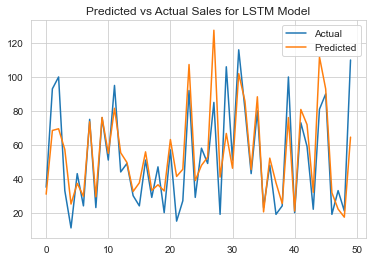

In [25]:
plot_pred_vs_act(Y_valid[:50],lstm_pred[:50],'LSTM')

<h1> XGBoost </h1>

In [44]:
# xgb_data = feature_engineering(preprocessed_data, conf['INDEX_COL'])

C:\Users\yashc\AppData\Local\Temp\ipykernel_16656\4087673004.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['weekofyear'] = data[date_col].dt.weekofyear


In [27]:
# Preprocess data to perform aggregation
xgb_train_x, xgb_test_x, xgb_train_y, xgb_test_y = train_test_split(
    processed_data.drop([f'{conf["INDEX_COL"]}', f'{conf["LABEL_COL"]}'],axis=1),
    processed_data[conf["LABEL_COL"]],
    test_size=0.2
)

In [28]:
# Train XGBoost model
xgb_model, xgb_test_data = xboost(conf['XGB_PARAMS'],
                                  MODEL_DIR,
                                  xgb_train_x,
                                  xgb_train_y,
                                  xgb_test_x,
                                  xgb_test_y,
                                  training_req=0
                                  )

In [29]:
# Get predictions from XGBoost model
xgb_predictions = pd.Series(xgb_model.predict(xgb_test_data))

# Transform predictions and actual data for SMAPE
xgb_predictions_reshaped = np.array(xgb_predictions).reshape(len(xgb_predictions),1)
xgb_test_y_reshaped = np.array(xgb_test_y).reshape(len(xgb_test_y),1)

In [30]:
# Get SMAPE for XGBoost
xgb_smape = SMAPE(xgb_predictions_reshaped, xgb_test_y_reshaped)

SMAPE Error Score: 15.21 %


In [31]:
# MSE Computation
xgb_mse = MSE(xgb_test_y_reshaped, xgb_predictions_reshaped)

<h1> Comparing the models' metrics </h1>

In [33]:
print(f'XGB SMAPE- {xgb_smape}%')
print(f'LSTM SMAPE- {lstm_smape}%')

print(f'XGB MSE- {xgb_mse:.2f}')
print(f'LSTM MSE- {lstm_mse:.2f}')

XGB SMAPE- 15.21%
LSTM SMAPE- 28.37%
XGB MSE- 67.66
LSTM MSE- 334.85


In [40]:
X_valid_series[0].transpose()

array([[25., 30., 16., 21., 21., 23., 26., 18., 29., 24., 21., 15., 23.,
        25., 22., 30., 20., 32., 25., 22., 35., 30., 44., 21., 22., 21.,
        23., 31., 36., 29.]])

In [41]:
Y_valid[0]

35.0

In [53]:
preprocessed_data

,item,store,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0
...,...,...,...,...
912995,50,10,2017-12-27,63.0
912996,50,10,2017-12-28,59.0
912997,50,10,2017-12-29,74.0
912998,50,10,2017-12-30,62.0


In [60]:
preprocessed_data.iloc[-30:]

,item,store,date,sales
912970,50,10,2017-12-02,49.0
912971,50,10,2017-12-03,75.0
912972,50,10,2017-12-04,54.0
912973,50,10,2017-12-05,68.0
912974,50,10,2017-12-06,60.0
912975,50,10,2017-12-07,66.0
912976,50,10,2017-12-08,67.0
912977,50,10,2017-12-09,69.0
912978,50,10,2017-12-10,69.0
912979,50,10,2017-12-11,54.0
